# SHAP Explainability in Turkish Text Classification

## Imports and Parameters

In [1]:
%load_ext autoreload
%autoreload 2

from itables import init_notebook_mode
init_notebook_mode(all_interactive=False)
from itables import show
import itables.options as opt
opt.style = "table-layout:auto; width:50%; margin-right:auto; margin-left:0;"
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)
# pd.reset_option('display.max_colwidth')
import pickle

import torch
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import shap

import sys
sys.path.append("Helper_Functions/") 
from general_utils import *
from shap_utils import *
from load_models import prepare_models

<IPython.core.display.Javascript object>

In [2]:
path_config = "Config/config.json"
config = load_hyperparameters(path_config)

path_ttc4900 = config["path_ttc4900"]
path_tr_news = config["path_tr_news"]
path_interpress = config["path_interpress"]
path_tc32 = config["path_tc32"]

path_bert_model_ttc4900 = config["path_bert_model_ttc4900"]
path_bert_model_tr_news = config["path_bert_model_tr_news"] 
path_bert_model_interpress = config["path_bert_model_interpress"]
path_bert_model_tc32 = config["path_bert_model_tc32"]

path_tbt_model_ttc4900 = config["path_tbt_model_ttc4900"]
path_tbt_model_tr_news = config["path_tbt_model_tr_news"] 
path_tbt_model_interpress = config["path_tbt_model_interpress"]
path_tbt_model_tc32 = config["path_tbt_model_tc32"]

path_shap = config["path_shap"]
thresholds = config["thresholds"]
only_load = config["only_load"]

path_reports = config["path_reports"]

pipeline_parameters = config["pipeline_parameters"]
device = torch.device(config["device"]) if torch.cuda.is_available() else torch.device("cpu")

display(pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']))

,Parameter,Value
0,path_ttc4900,Data/TTC_4900/
1,path_tr_news,Data/TR_News/
2,path_interpress,Data/Interpress/
3,path_tc32,Data/TC32/
4,path_bert_model_ttc4900,Models/bertturk_text_classification_fine_tuned_ttc4900
5,path_bert_model_tr_news,Models/bertturk_text_classification_fine_tuned_tr_news
6,path_bert_model_interpress,Models/bertturk_text_classification_fine_tuned_interpress
7,path_bert_model_tc32,Models/bertturk_text_classification_fine_tuned_tc32
8,path_tbt_model_ttc4900,Models/turkishbertweet_text_classification_fine_tuned_ttc4900
9,path_tbt_model_tr_news,Models/turkishbertweet_text_classification_fine_tuned_tr_news


## Load Datasets

In [3]:
from load_datasets import prepare_datasets

ttc4900_test, tr_news_test, interpress_test, tc32_test = prepare_datasets(path_ttc4900, path_tr_news, path_interpress, path_tc32)

print("TTC 4900 Test Set:\n\n", ttc4900_test)
print("\nTR News Test Set:\n\n", tr_news_test)
print("\nInterpress Test Set:\n\n", interpress_test)
print("\nTC 32 Test Set:\n\n", tc32_test)

TTC 4900 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 735
})

TR News Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 880
})

Interpress Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

TC 32 Test Set:

 Dataset({
    features: ['text', 'label'],
    num_rows: 9600
})


## SHAP Explainability

In [12]:
all_exp_results = pd.DataFrame(columns=["Cl Acc", "ECS FT", "ECS TT", "ORC (+)", "ORC (-)"])

### BERTTurk

#### Inference on Full Text

In [7]:
# Load BERTTurk models

bert_model_ttc4900, \
bert_tokenizer_ttc4900, \
bert_config_ttc4900, \
bert_pipeline_text_ttc4900, \
bert_label2id_ttc4900, \
bert_id2label_ttc4900 = prepare_models(path_bert_model_ttc4900, device)

bert_model_tr_news, \
bert_tokenizer_tr_news, \
bert_config_tr_news, \
bert_pipeline_text_tr_news, \
bert_label2id_tr_news, \
bert_id2label_tr_news = prepare_models(path_bert_model_tr_news, device)

bert_model_interpress, \
bert_tokenizer_interpress, \
bert_config_interpress, \
bert_pipeline_text_interpress, \
bert_label2id_interpress, \
bert_id2label_interpress = prepare_models(path_bert_model_interpress, device)

bert_model_tc32, \
bert_tokenizer_tc32, \
bert_config_tc32, \
bert_pipeline_text_tc32, \
bert_label2id_tc32, \
bert_id2label_tc32 = prepare_models(path_bert_model_tc32, device)

Error caught was: No module named 'triton'



'bertturk_text_classification_fine_tuned_ttc4900' is loaded.

'bertturk_text_classification_fine_tuned_tr_news' is loaded.

'bertturk_text_classification_fine_tuned_interpress' is loaded.

'bertturk_text_classification_fine_tuned_tc32' is loaded.


In [6]:
# predict_parameter_set_ttc4900 = {
#     'model': bert_model_ttc4900,
#     'tokenizer': bert_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': bert_model_tr_news,
#     'tokenizer': bert_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': bert_model_interpress,
#     'tokenizer': bert_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': bert_model_tc32,
#     'tokenizer': bert_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': bert_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# bert_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, bert_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# bert_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, bert_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# bert_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, bert_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# bert_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, bert_label2id_tc32)

# path_classification_results = "Data/Classification_Results/BERTTurk/"

# with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tr_news, file)

# with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_interpress, file)

# with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(bert_full_text_preds_tc32, file)

In [8]:
path_classification_results = "Data/Classification_Results/BERTTurk/"

with open(path_classification_results + 'bert_full_text_preds_ttc4900.pkl', 'rb') as file:
    bert_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tr_news.pkl', 'rb') as file:
    bert_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_interpress.pkl', 'rb') as file:
    bert_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'bert_full_text_preds_tc32.pkl', 'rb') as file:
    bert_full_text_preds_tc32 = pickle.load(file)

In [9]:
num_samples = 100

ttc4900_test = ttc4900_test.select(range(num_samples))
tr_news_test = tr_news_test.select(range(num_samples))
interpress_test = interpress_test.select(range(num_samples))
tc32_test = tc32_test.select(range(num_samples))

bert_full_text_preds_ttc4900 = bert_full_text_preds_ttc4900[:num_samples]
bert_full_text_preds_tr_news = bert_full_text_preds_tr_news[:num_samples]
bert_full_text_preds_interpress = bert_full_text_preds_interpress[:num_samples]
bert_full_text_preds_tc32 = bert_full_text_preds_tc32[:num_samples]

#### TTC4900

In [10]:
shap_explainer_ttc4900 = shap.Explainer(bert_pipeline_text_ttc4900)
ttc4900_bert_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_bert", 
                                                    shap_explainer_ttc4900, 
                                                    bert_full_text_preds_ttc4900, len(bert_label2id_ttc4900),
                                                    only_load=only_load)

    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, threshold)
    
    ttc4900_bert_result = compare_probs(ttc4900_test,
                                        bert_full_text_preds_ttc4900,
                                        top_tokens_ttc4900,
                                        None,
                                        bert_model_ttc4900, bert_tokenizer_ttc4900,
                                        id2label=bert_id2label_ttc4900,
                                        device=device)

    ttc4900_bert_results[threshold] = (shap_values_ttc, ttc4900_bert_result)
    
    clear_gpu_memory()
    
    show(ttc4900_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_ttc_0.5_bert' file shape: (100, None, 7)


'shap_values_ttc_0.6_bert' file shape: (100, None, 7)


'shap_values_ttc_0.7_bert' file shape: (100, None, 7)


In [10]:
# sample_no = 4

# shap.plots.text(ttc4900_bert_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_bert_results[0.7][1][sample_no])


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.906
Overall Relative Change (ORC) positive changes      :  8.504 %
Overall Relative Change (ORC) negative changes      : -9.251 %


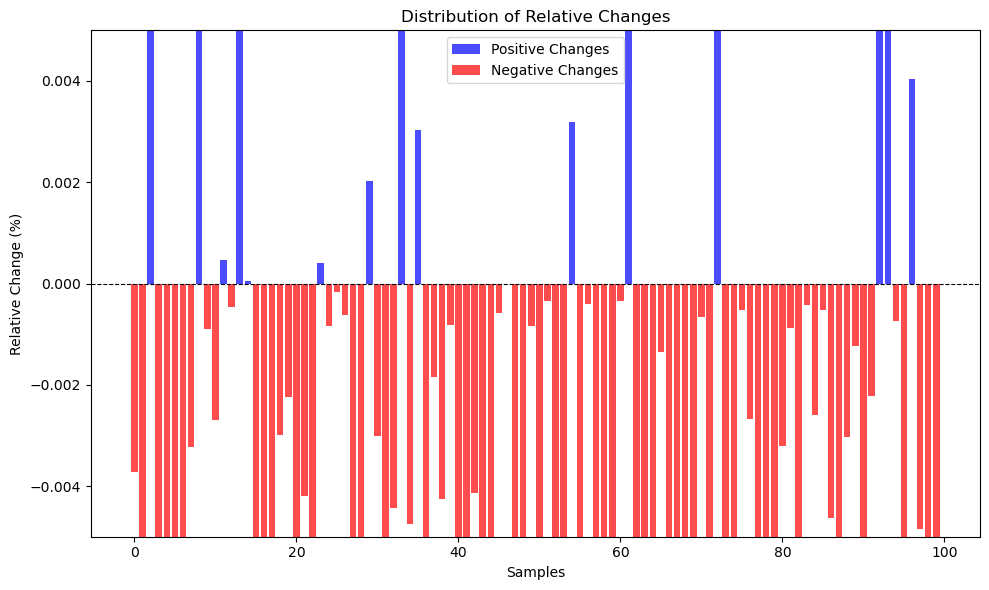


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.909
Overall Relative Change (ORC) positive changes      :  7.011 %
Overall Relative Change (ORC) negative changes      : -9.055 %


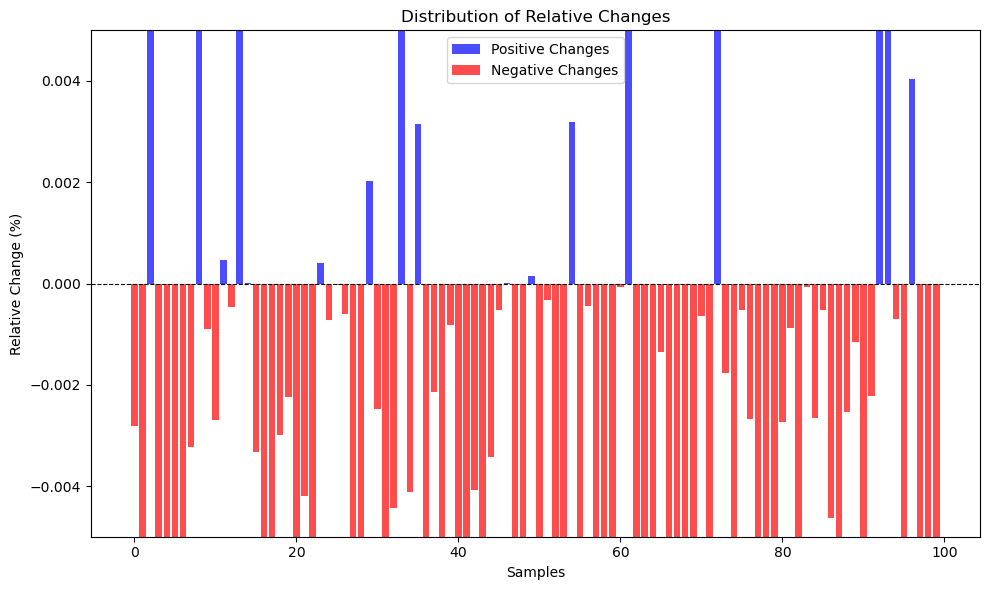


Classification accuracy                             :  0.88
Explanations Contribution Score (ECS) of Full Text  :  0.972
Explanations Contribution Score (ECS) of Top Tokens :  0.915
Overall Relative Change (ORC) positive changes      :  6.581 %
Overall Relative Change (ORC) negative changes      : -8.413 %


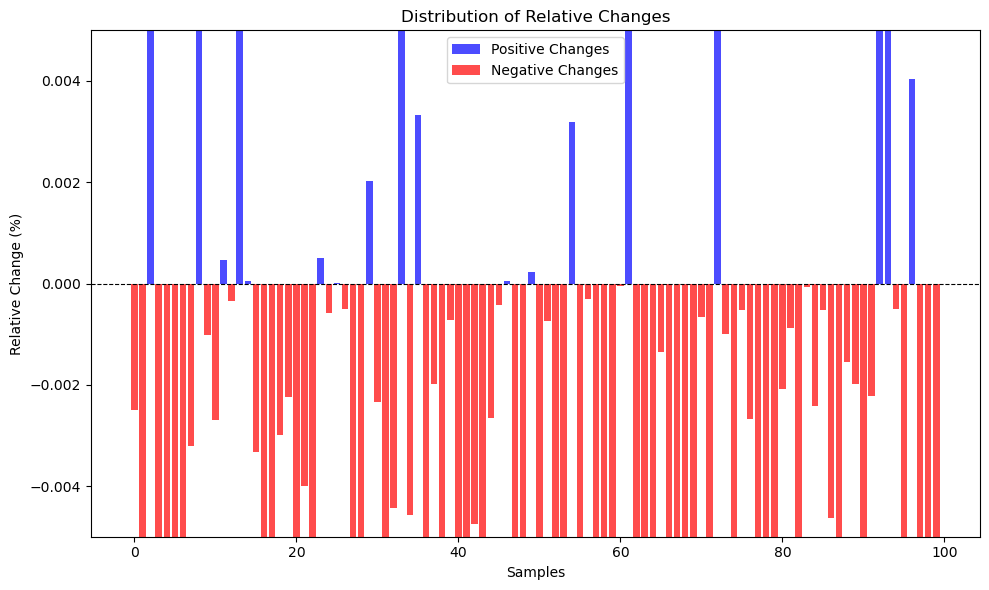

In [13]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [14]:
shap_explainer_tr_news = shap.Explainer(bert_pipeline_text_tr_news)
tr_news_bert_results = {}

for threshold in thresholds:
    
    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_bert", 
                                                            shap_explainer_tr_news,
                                                            bert_full_text_preds_tr_news, len(bert_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, threshold)
    
    tr_news_bert_result = compare_probs(tr_news_test,
                                        bert_full_text_preds_tr_news,
                                        top_tokens_tr_news,
                                        None,
                                        bert_model_tr_news, bert_tokenizer_tr_news,
                                        id2label=bert_id2label_tr_news,
                                        device=device)

    tr_news_bert_results[threshold] = (shap_values_tr_news, tr_news_bert_result)
    
    clear_gpu_memory()

    show(tr_news_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tr_news_0.5_bert' file shape: (100, None, 11)


'shap_values_tr_news_0.6_bert' file shape: (100, None, 11)


'shap_values_tr_news_0.7_bert' file shape: (100, None, 11)


In [15]:
# sample_no = 8

# shap.plots.text(tr_news_bert_results[0.5][0][sample_no])
# shap.plots.text(tr_news_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.556
Overall Relative Change (ORC) positive changes      :  6.708 %
Overall Relative Change (ORC) negative changes      : -32.169 %


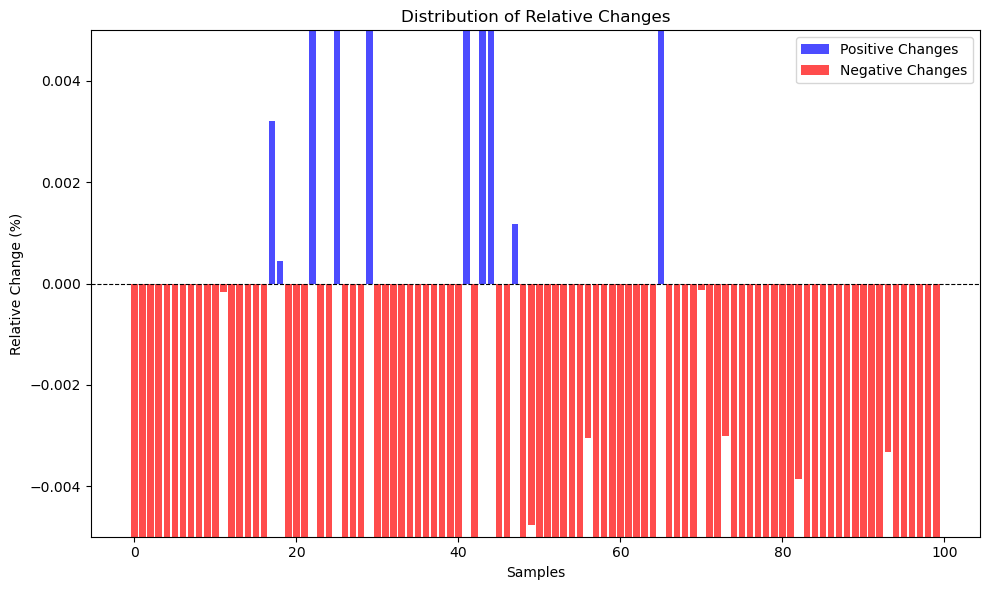


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.562
Overall Relative Change (ORC) positive changes      :  6.142 %
Overall Relative Change (ORC) negative changes      : -33.242 %


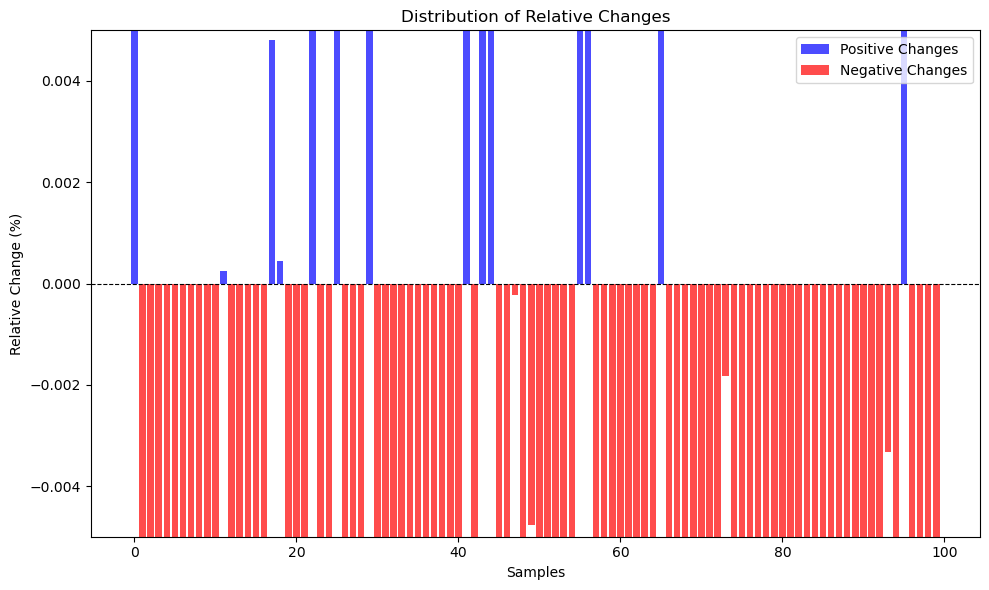


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.839
Explanations Contribution Score (ECS) of Top Tokens :  0.54
Overall Relative Change (ORC) positive changes      :  7.347 %
Overall Relative Change (ORC) negative changes      : -34.972 %


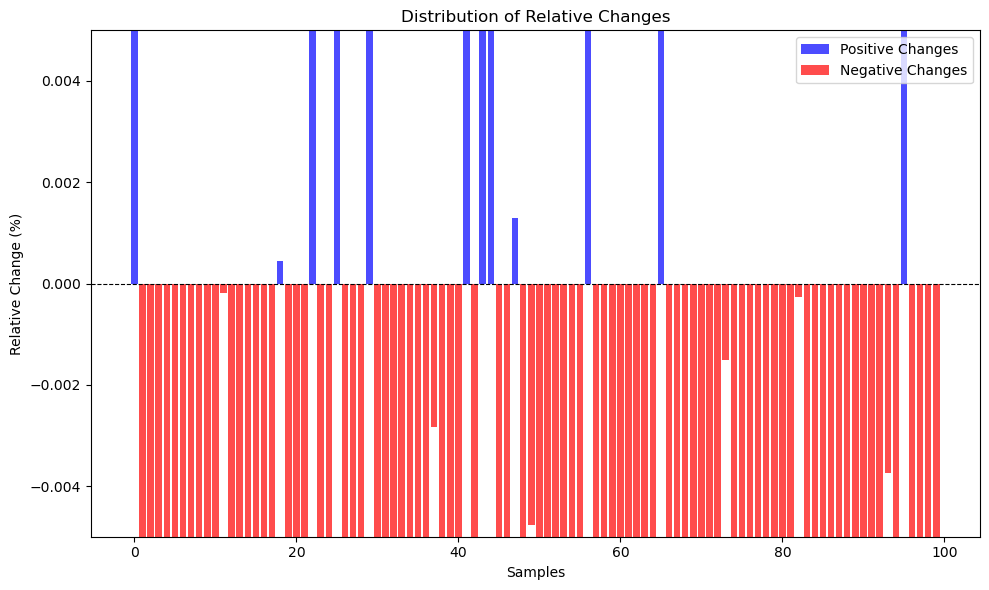

In [16]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [17]:
shap_explainer_interpress = shap.Explainer(bert_pipeline_text_interpress)
interpress_bert_results = {}

for threshold in thresholds:
    
    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_bert", 
                                                                  shap_explainer_interpress, 
                                                                  bert_full_text_preds_interpress, len(bert_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, threshold)

    interpress_bert_result = compare_probs(interpress_test,
                                           bert_full_text_preds_interpress,
                                           top_tokens_interpress,
                                           None,
                                           bert_model_interpress, bert_tokenizer_interpress,
                                           id2label=bert_id2label_interpress,
                                           device=device)

    interpress_bert_results[threshold] = (shap_values_interpress, interpress_bert_result)
    
    clear_gpu_memory()
    
    show(interpress_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_interpress_0.5_bert' file shape: (100, None, 10)


'shap_values_interpress_0.6_bert' file shape: (100, None, 10)


'shap_values_interpress_0.7_bert' file shape: (100, None, 10)


In [18]:
# sample_no = 10

# shap.plots.text(interpress_bert_results[0.5][0][sample_no])
# shap.plots.text(interpress_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.712
Overall Relative Change (ORC) positive changes      :  9.009 %
Overall Relative Change (ORC) negative changes      : -30.453 %


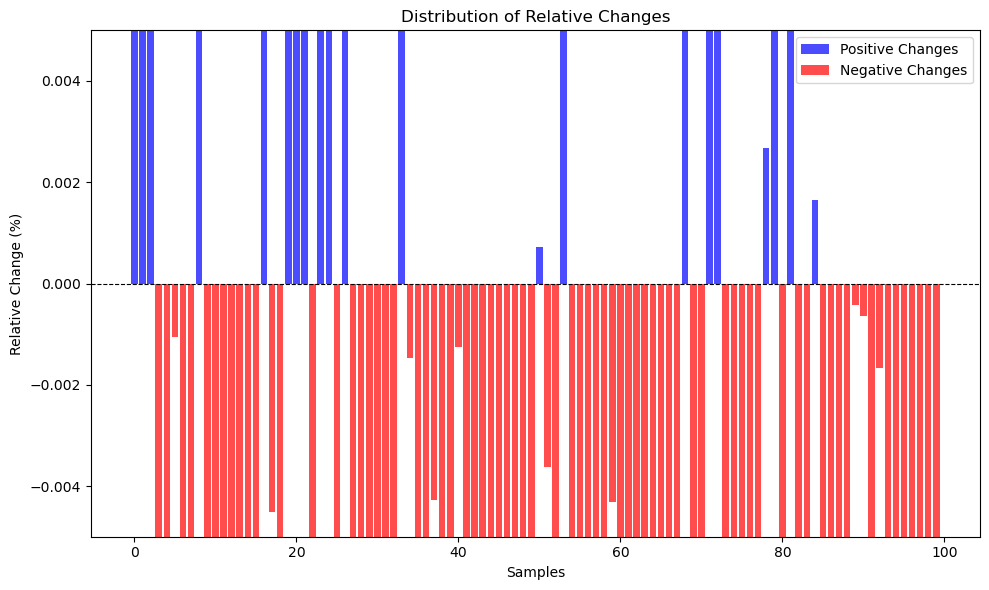


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.698
Overall Relative Change (ORC) positive changes      :  8.254 %
Overall Relative Change (ORC) negative changes      : -32.56 %


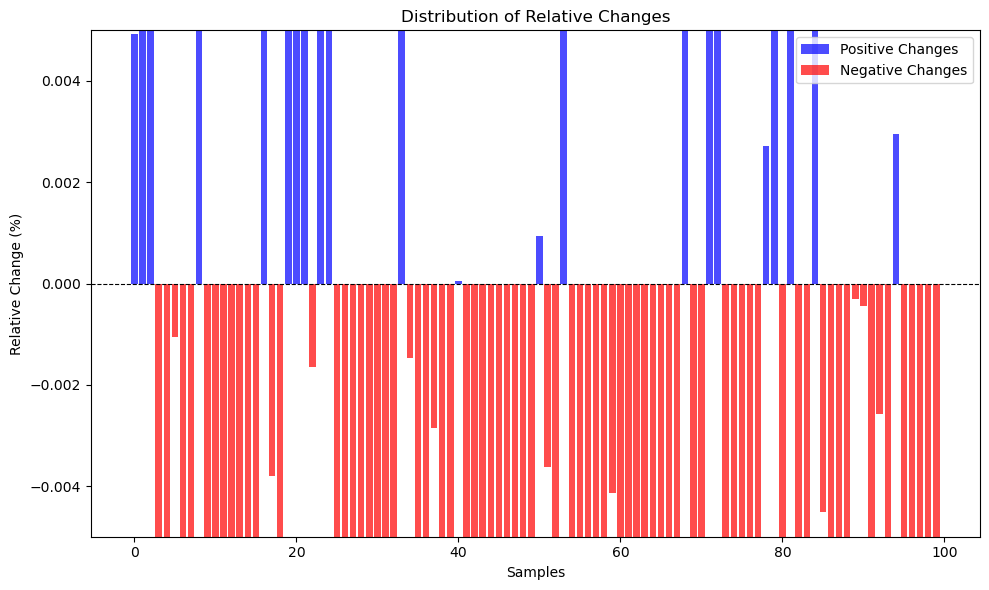


Classification accuracy                             :  0.84
Explanations Contribution Score (ECS) of Full Text  :  0.934
Explanations Contribution Score (ECS) of Top Tokens :  0.716
Overall Relative Change (ORC) positive changes      :  8.231 %
Overall Relative Change (ORC) negative changes      : -29.77 %


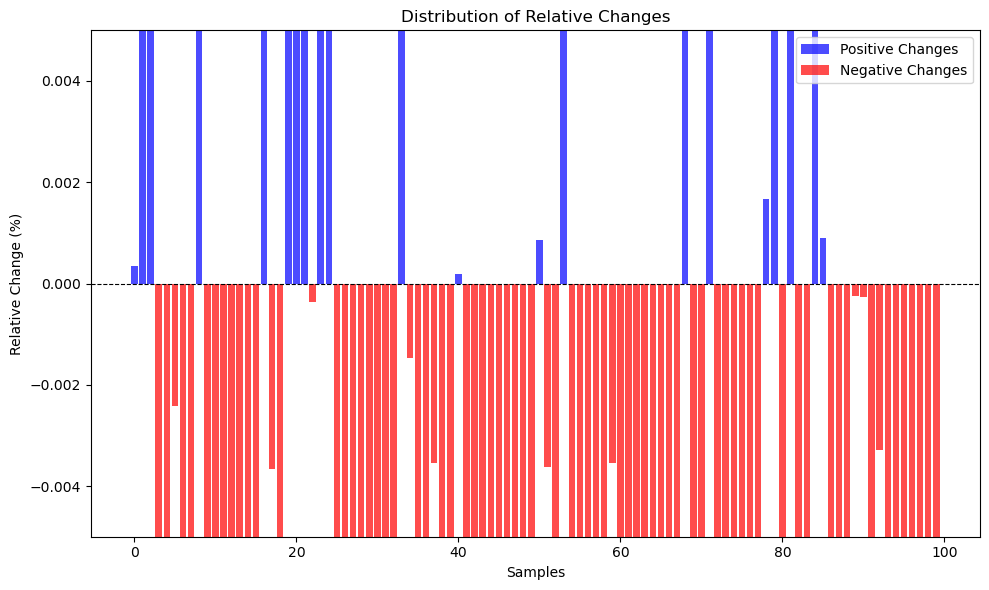

In [19]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [20]:
shap_explainer_tc32 = shap.Explainer(bert_pipeline_text_tc32)
tc32_bert_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_bert", 
                                                      shap_explainer_tc32, 
                                                      bert_full_text_preds_tc32, len(bert_label2id_tc32),
                                                      only_load=only_load)

    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, threshold)
    
    tc32_bert_result = compare_probs(tc32_test,
                                     bert_full_text_preds_tc32,
                                     top_tokens_tc32,
                                     None,
                                     bert_model_tc32, bert_tokenizer_tc32,
                                     id2label=bert_id2label_tc32,
                                     device=device)

    tc32_bert_results[threshold] = (shap_values_tc32, tc32_bert_result)
    
    clear_gpu_memory()
    
    show(tc32_bert_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tc32_0.5_bert' file shape: (100, None, 32)


'shap_values_tc32_0.6_bert' file shape: (100, None, 32)


'shap_values_tc32_0.7_bert' file shape: (100, None, 32)


In [21]:
# sample_no = 3

# shap.plots.text(tc32_bert_results[0.5][0][sample_no])
# shap.plots.text(tc32_bert_results[0.5][1][sample_no])


Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.489
Overall Relative Change (ORC) positive changes      :  10.597 %
Overall Relative Change (ORC) negative changes      : -51.56 %


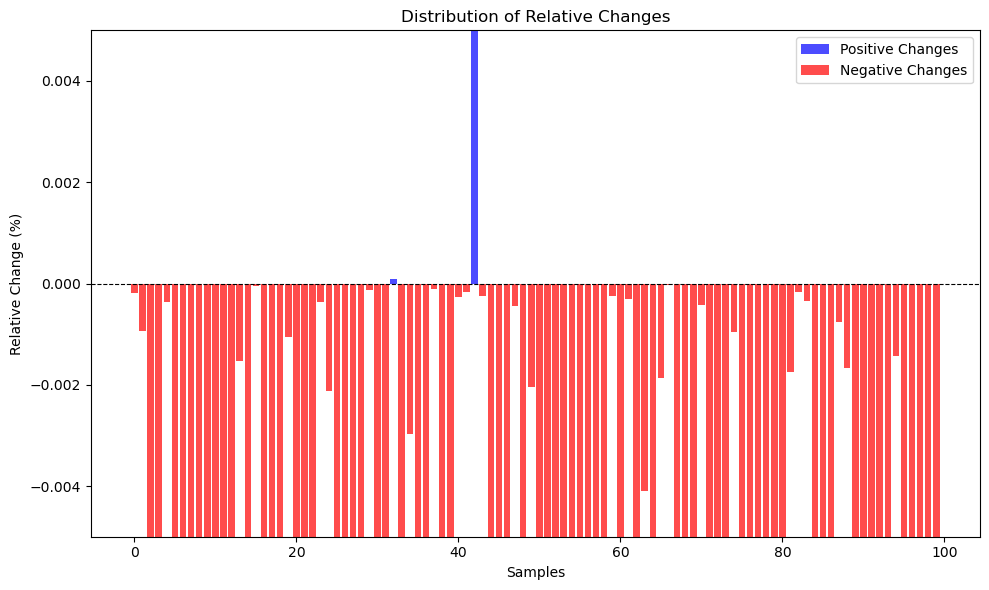


Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.492
Overall Relative Change (ORC) positive changes      :  4.272 %
Overall Relative Change (ORC) negative changes      : -52.939 %


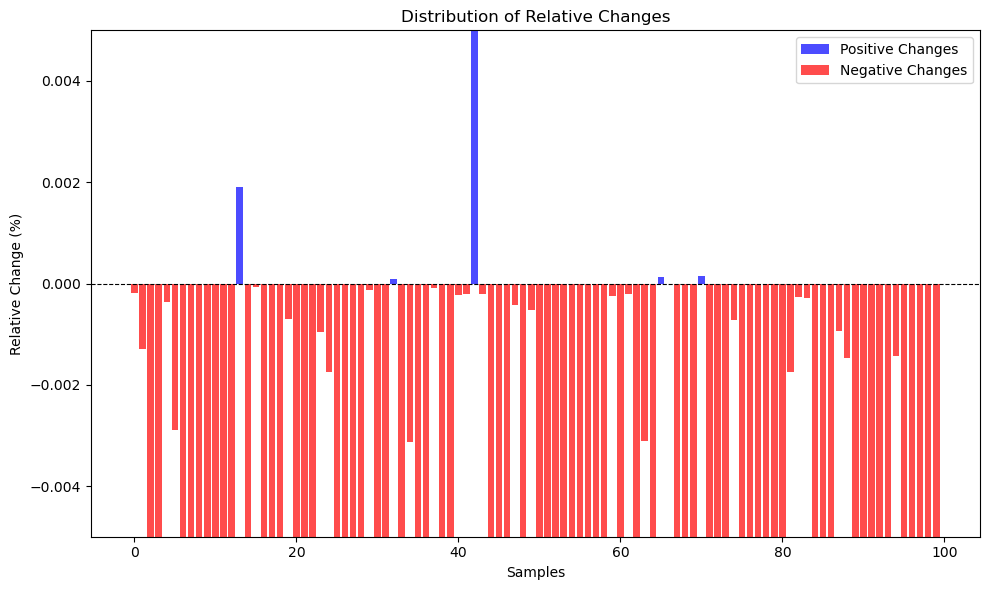


Classification accuracy                             :  0.95
Explanations Contribution Score (ECS) of Full Text  :  0.993
Explanations Contribution Score (ECS) of Top Tokens :  0.493
Overall Relative Change (ORC) positive changes      :  5.339 %
Overall Relative Change (ORC) negative changes      : -52.314 %


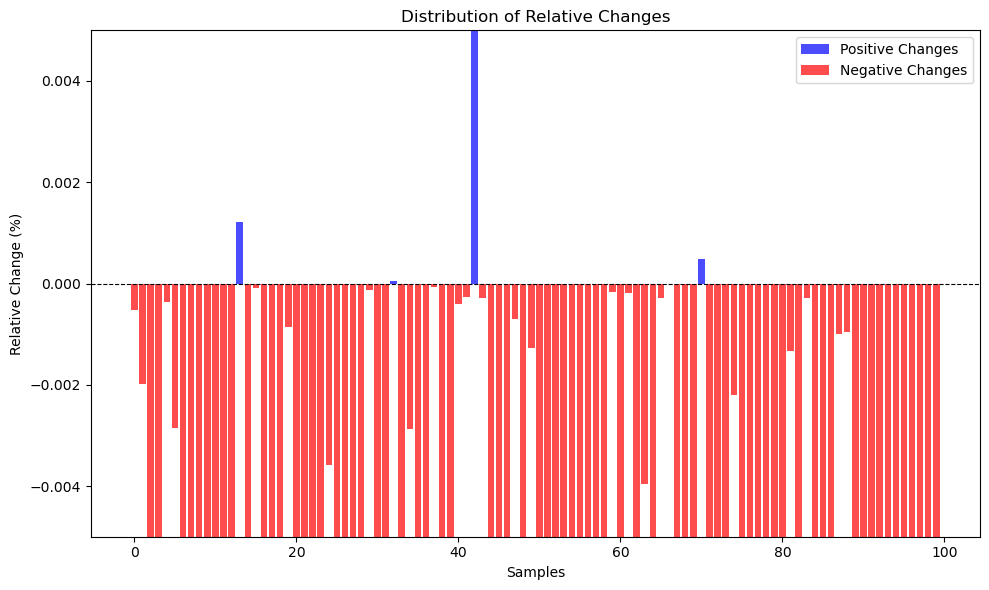

In [22]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_bert_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

### TurkishBERTweet

#### Inference on Full Text

In [23]:
# Load TurkishBERTweet models

tbt_model_ttc4900, \
tbt_tokenizer_ttc4900, \
tbt_config_ttc4900, \
tbt_pipeline_text_ttc4900, \
tbt_label2id_ttc4900, \
tbt_id2label_ttc4900 = prepare_models(path_tbt_model_ttc4900, device)

tbt_model_tr_news, \
tbt_tokenizer_tr_news, \
tbt_config_tr_news, \
tbt_pipeline_text_tr_news, \
tbt_label2id_tr_news, \
tbt_id2label_tr_news = prepare_models(path_tbt_model_tr_news, device)

tbt_model_interpress, \
tbt_tokenizer_interpress, \
tbt_config_interpress, \
tbt_pipeline_text_interpress, \
tbt_label2id_interpress, \
tbt_id2label_interpress = prepare_models(path_tbt_model_interpress, device)

tbt_model_tc32, \
tbt_tokenizer_tc32, \
tbt_config_tc32, \
tbt_pipeline_text_tc32, \
tbt_label2id_tc32, \
tbt_id2label_tc32 = prepare_models(path_tbt_model_tc32, device)


'turkishbertweet_text_classification_fine_tuned_ttc4900' is loaded.

'turkishbertweet_text_classification_fine_tuned_tr_news' is loaded.

'turkishbertweet_text_classification_fine_tuned_interpress' is loaded.

'turkishbertweet_text_classification_fine_tuned_tc32' is loaded.


In [22]:
# predict_parameter_set_ttc4900 = {
#     'model': tbt_model_ttc4900,
#     'tokenizer': tbt_tokenizer_ttc4900,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_ttc4900,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tr_news = {
#     'model': tbt_model_tr_news,
#     'tokenizer': tbt_tokenizer_tr_news,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tr_news,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_interpress = {
#     'model': tbt_model_interpress,
#     'tokenizer': tbt_tokenizer_interpress,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_interpress,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# predict_parameter_set_tc32 = {
#     'model': tbt_model_tc32,
#     'tokenizer': tbt_tokenizer_tc32,
#     'top_k': 1,
#     'mode': 'pipeline',
#     'text_pipeline': tbt_pipeline_text_tc32,
#     'pipeline_parameters': pipeline_parameters,
#     'max_length': 128,
#     'device': device,
#     'multi_sample': True
# }

# print("\nClassification metrics of full text prediction of TTC 4900:\n")
# tbt_full_text_preds_ttc4900 = evaluate_classification(ttc4900_test, predict_parameter_set_ttc4900, tbt_label2id_ttc4900)

# print("\nClassification metrics of full text prediction of TR News:\n")
# tbt_full_text_preds_tr_news = evaluate_classification(tr_news_test, predict_parameter_set_tr_news, tbt_label2id_tr_news)

# print("\nClassification metrics of full text prediction of Interpress:\n")
# tbt_full_text_preds_interpress = evaluate_classification(interpress_test, predict_parameter_set_interpress, tbt_label2id_interpress)

# print("\nClassification metrics of full text prediction of TC 32:\n")
# tbt_full_text_preds_tc32 = evaluate_classification(tc32_test, predict_parameter_set_tc32, tbt_label2id_tc32)

# path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

# with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_ttc4900, file)

# with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tr_news, file)

# with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_interpress, file)

# with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'wb') as file:
#     pickle.dump(tbt_full_text_preds_tc32, file)

In [24]:
path_classification_results = "Data/Classification_Results/TurkishBERTweet/"

with open(path_classification_results + 'tbt_full_text_preds_ttc4900.pkl', 'rb') as file:
    tbt_full_text_preds_ttc4900 = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tr_news.pkl', 'rb') as file:
    tbt_full_text_preds_tr_news = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_interpress.pkl', 'rb') as file:
    tbt_full_text_preds_interpress = pickle.load(file)

with open(path_classification_results + 'tbt_full_text_preds_tc32.pkl', 'rb') as file:
    tbt_full_text_preds_tc32 = pickle.load(file)

In [25]:
tbt_full_text_preds_ttc4900 = tbt_full_text_preds_ttc4900[:num_samples]
tbt_full_text_preds_tr_news = tbt_full_text_preds_tr_news[:num_samples]
tbt_full_text_preds_interpress = tbt_full_text_preds_interpress[:num_samples]
tbt_full_text_preds_tc32 = tbt_full_text_preds_tc32[:num_samples]

#### TTC4900

In [26]:
shap_explainer_ttc4900 = shap.Explainer(tbt_pipeline_text_ttc4900)
ttc4900_tbt_results = {}

for threshold in thresholds:

    shap_values_ttc, tokens_values_ttc = apply_shap(path_shap, ttc4900_test, 
                                                    f"shap_values_ttc_{threshold}_tbt", 
                                                    shap_explainer_ttc4900, 
                                                    tbt_full_text_preds_ttc4900, len(tbt_label2id_ttc4900),
                                                    only_load=only_load)
    
    top_tokens_ttc4900 = apply_thresholding(tokens_values_ttc, threshold)
    
    ttc4900_tbt_result = compare_probs(ttc4900_test,
                                       tbt_full_text_preds_ttc4900,
                                       top_tokens_ttc4900,
                                       None,
                                       tbt_model_ttc4900, tbt_tokenizer_ttc4900,
                                       id2label=tbt_id2label_ttc4900,
                                       device=device)

    ttc4900_tbt_results[threshold] = (shap_values_ttc, ttc4900_tbt_result)
    
    clear_gpu_memory()
    
    show(ttc4900_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_ttc_0.5_tbt' file shape: (100, None, 7)


'shap_values_ttc_0.6_tbt' file shape: (100, None, 7)


'shap_values_ttc_0.7_tbt' file shape: (100, None, 7)


In [27]:
# sample_no = 4

# shap.plots.text(ttc4900_tbt_results[0.7][0][sample_no])
# shap.plots.text(ttc4900_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.8
Overall Relative Change (ORC) positive changes      :  3.842 %
Overall Relative Change (ORC) negative changes      : -26.609 %


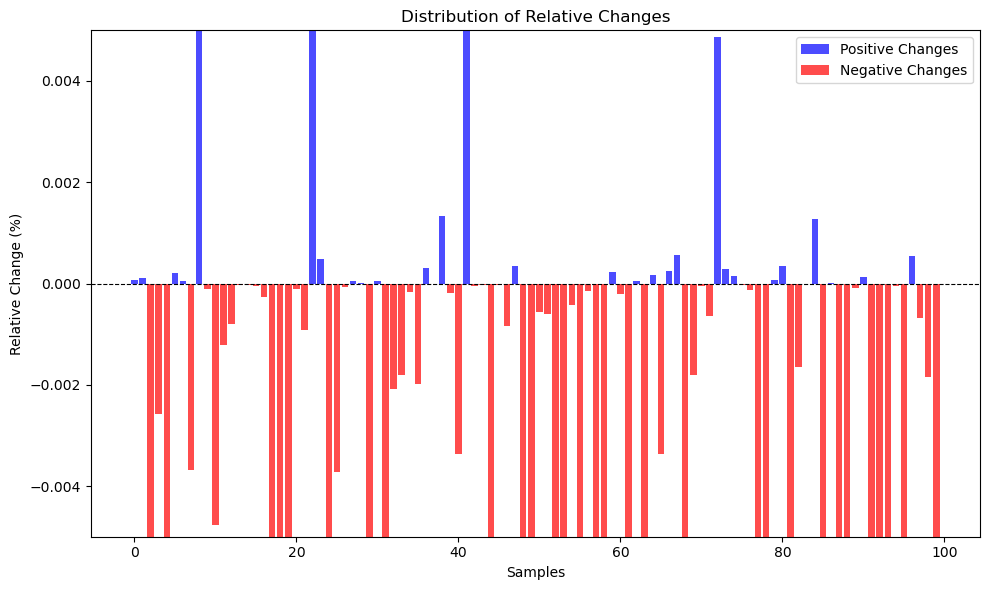


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.811
Overall Relative Change (ORC) positive changes      :  3.667 %
Overall Relative Change (ORC) negative changes      : -25.404 %


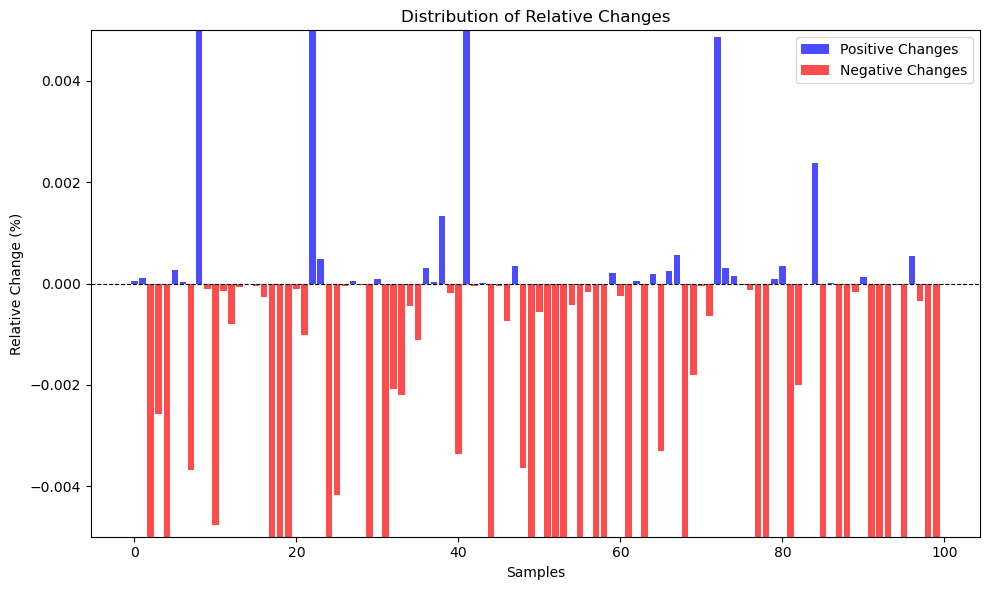


Classification accuracy                             :  0.9
Explanations Contribution Score (ECS) of Full Text  :  0.98
Explanations Contribution Score (ECS) of Top Tokens :  0.811
Overall Relative Change (ORC) positive changes      :  3.657 %
Overall Relative Change (ORC) negative changes      : -24.893 %


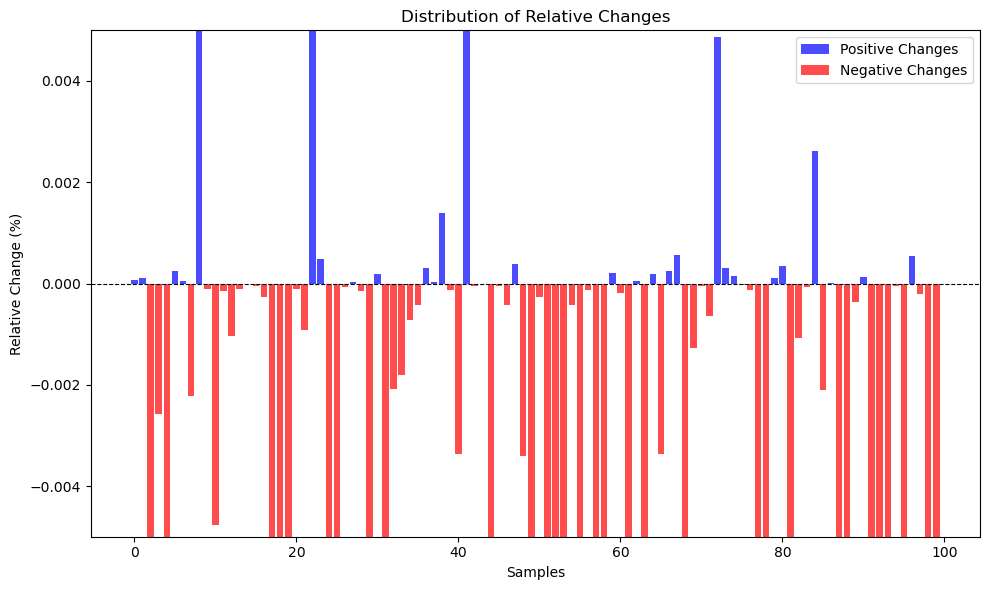

In [28]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(ttc4900_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TR News

In [29]:
shap_explainer_tr_news = shap.Explainer(tbt_pipeline_text_tr_news)
tr_news_tbt_results = {}

for threshold in thresholds:

    shap_values_tr_news, tokens_values_tr_news = apply_shap(path_shap, tr_news_test, 
                                                            f"shap_values_tr_news_{threshold}_tbt", 
                                                            shap_explainer_tr_news,
                                                            tbt_full_text_preds_tr_news, len(tbt_label2id_tr_news),
                                                            only_load=only_load)
    
    top_tokens_tr_news = apply_thresholding(tokens_values_tr_news, threshold)
    
    tr_news_tbt_result = compare_probs(tr_news_test,
                                       tbt_full_text_preds_tr_news,
                                       top_tokens_tr_news,
                                       None,
                                       tbt_model_tr_news, tbt_tokenizer_tr_news,
                                       id2label=tbt_id2label_tr_news,
                                       device=device)

    tr_news_tbt_results[threshold] = (shap_values_tr_news, tr_news_tbt_result)
    
    clear_gpu_memory()
    
    show(tr_news_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_tr_news_0.5_tbt' file shape: (100, None, 11)


'shap_values_tr_news_0.6_tbt' file shape: (100, None, 11)


'shap_values_tr_news_0.7_tbt' file shape: (100, None, 11)


In [30]:
# sample_no = 4

# shap.plots.text(tr_news_tbt_results[0.7][0][sample_no])
# shap.plots.text(tr_news_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.482
Overall Relative Change (ORC) positive changes      :  9.503 %
Overall Relative Change (ORC) negative changes      : -36.349 %


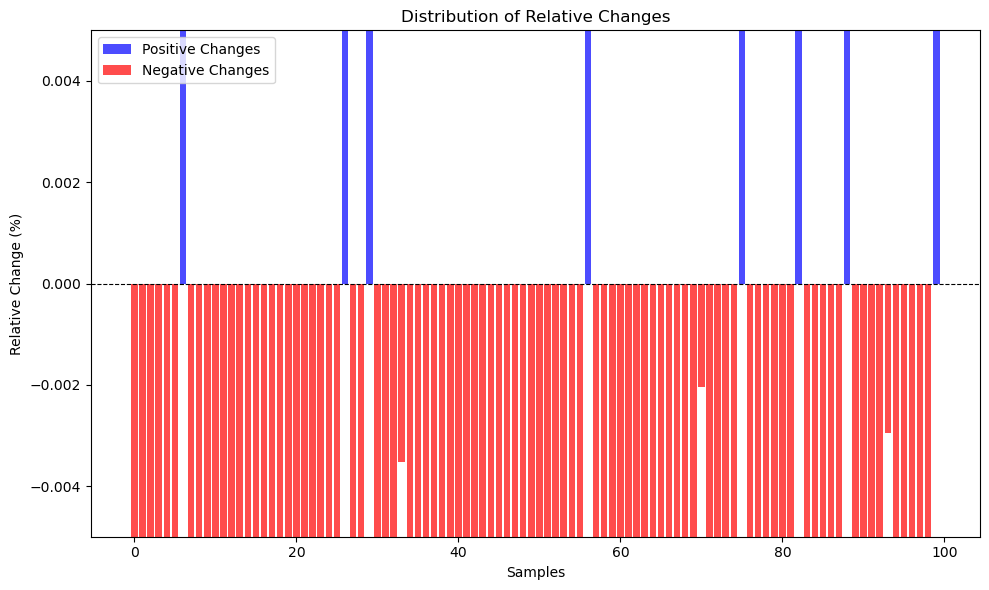


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.47
Overall Relative Change (ORC) positive changes      :  11.543 %
Overall Relative Change (ORC) negative changes      : -37.916 %


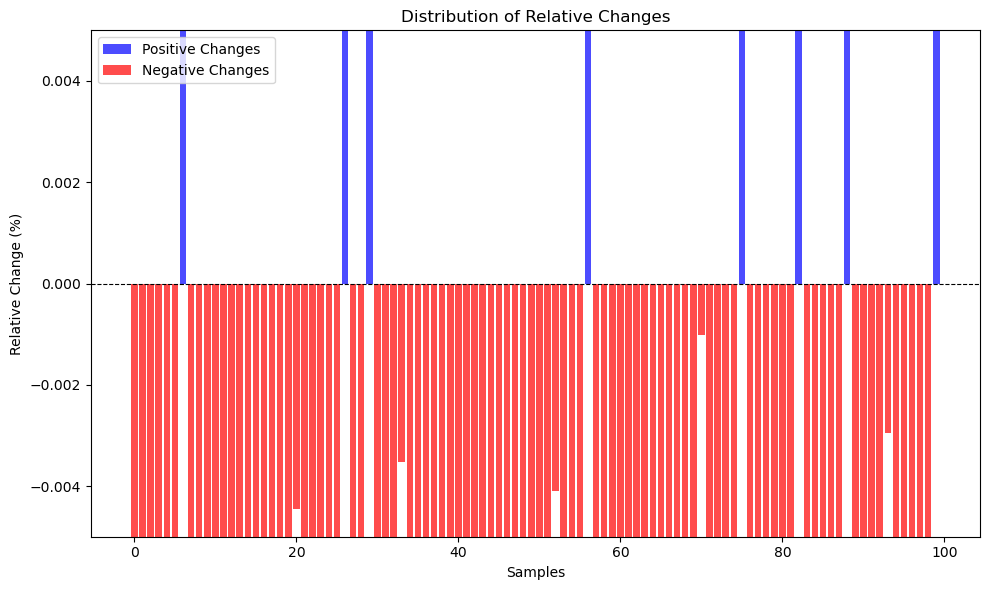


Classification accuracy                             :  0.7
Explanations Contribution Score (ECS) of Full Text  :  0.809
Explanations Contribution Score (ECS) of Top Tokens :  0.45
Overall Relative Change (ORC) positive changes      :  9.725 %
Overall Relative Change (ORC) negative changes      : -40.481 %


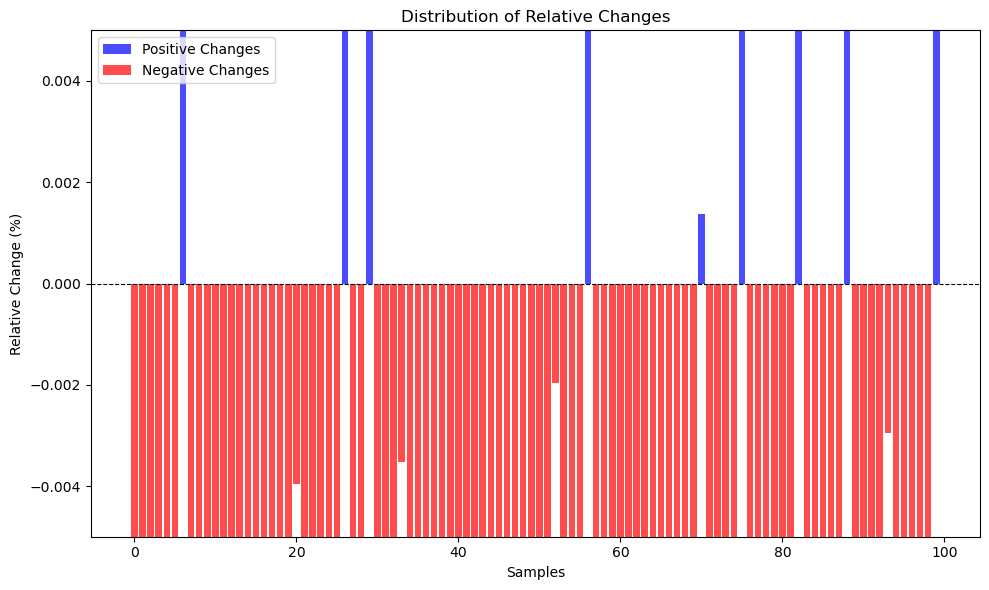

In [31]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tr_news_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### Interpress

In [32]:
shap_explainer_interpress = shap.Explainer(tbt_pipeline_text_interpress)
interpress_tbt_results = {}

for threshold in thresholds:

    shap_values_interpress, tokens_values_interpress = apply_shap(path_shap, interpress_test, 
                                                                  f"shap_values_interpress_{threshold}_tbt", 
                                                                  shap_explainer_interpress,
                                                                  tbt_full_text_preds_interpress, len(tbt_label2id_interpress),
                                                                  only_load=only_load)
    
    top_tokens_interpress = apply_thresholding(tokens_values_interpress, threshold)
    
    interpress_tbt_result = compare_probs(interpress_test,
                                          tbt_full_text_preds_interpress,
                                          top_tokens_interpress,
                                          None,
                                          tbt_model_interpress, tbt_tokenizer_interpress,
                                          id2label=tbt_id2label_interpress,
                                          device=device)

    interpress_tbt_results[threshold] = (shap_values_interpress, interpress_tbt_result)
    
    clear_gpu_memory()
    
    show(interpress_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

'shap_values_interpress_0.5_tbt' file shape: (100, None, 10)


'shap_values_interpress_0.6_tbt' file shape: (100, None, 10)


'shap_values_interpress_0.7_tbt' file shape: (100, None, 10)


In [33]:
# sample_no = 23

# shap.plots.text(interpress_tbt_results[0.7][0][sample_no])
# shap.plots.text(interpress_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.355
Overall Relative Change (ORC) positive changes      :  16.707 %
Overall Relative Change (ORC) negative changes      : -59.436 %


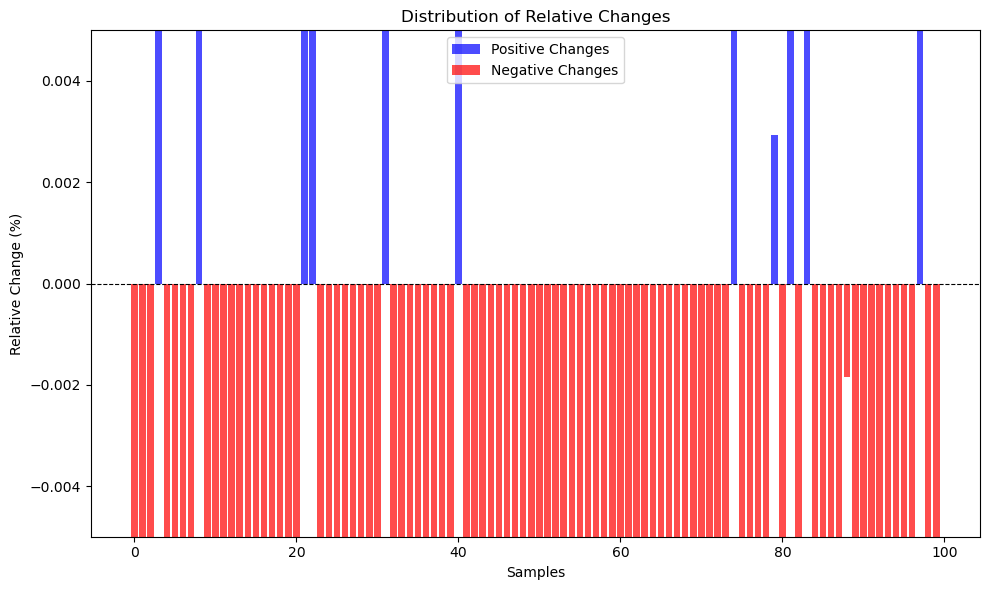


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.364
Overall Relative Change (ORC) positive changes      :  18.256 %
Overall Relative Change (ORC) negative changes      : -58.558 %


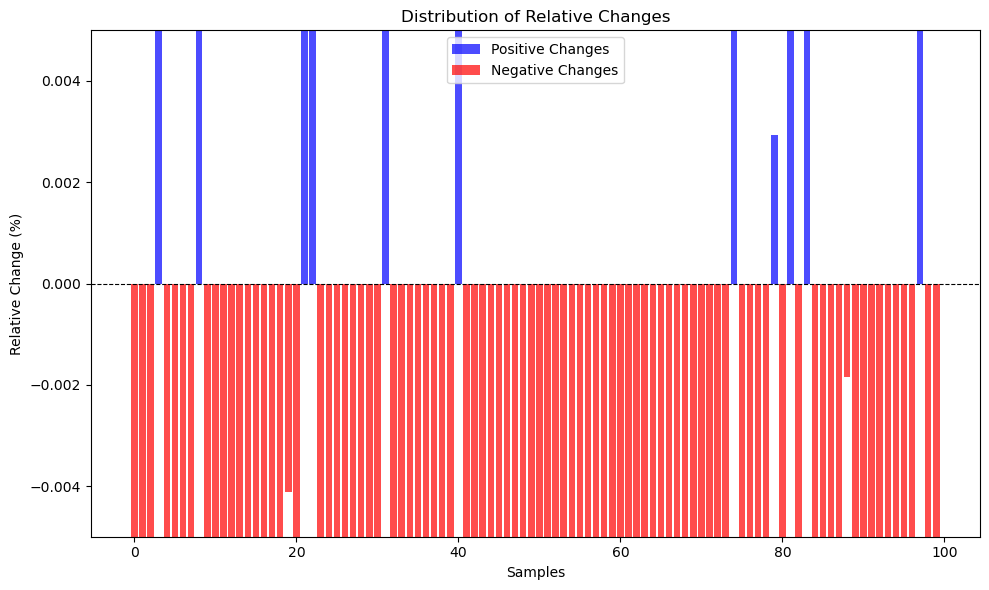


Classification accuracy                             :  0.75
Explanations Contribution Score (ECS) of Full Text  :  0.865
Explanations Contribution Score (ECS) of Top Tokens :  0.38
Overall Relative Change (ORC) positive changes      :  19.667 %
Overall Relative Change (ORC) negative changes      : -56.924 %


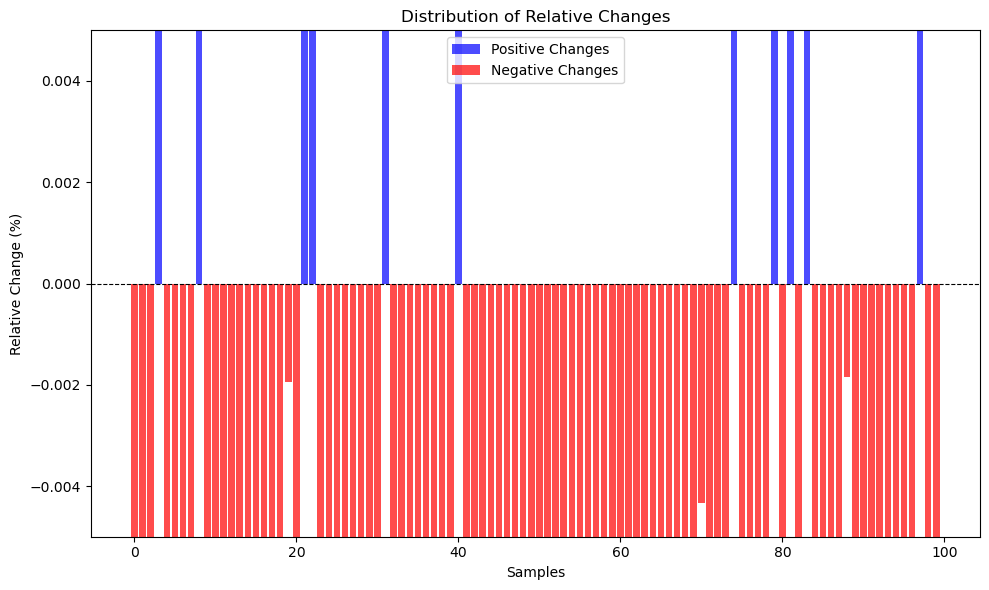

In [34]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(interpress_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

#### TC32

In [52]:
shap_explainer_tc32 = shap.Explainer(tbt_pipeline_text_tc32)
tc32_tbt_results = {}

for threshold in thresholds:

    shap_values_tc32, tokens_values_tc32 = apply_shap(path_shap, tc32_test, 
                                                      f"shap_values_tc32_{threshold}_tbt", 
                                                      shap_explainer_tc32, 
                                                      tbt_full_text_preds_tc32, len(tbt_label2id_tc32),
                                                      only_load=only_load)
    
    top_tokens_tc32 = apply_thresholding(tokens_values_tc32, threshold)
    
    tc32_tbt_result = compare_probs(tc32_test,
                                    tbt_full_text_preds_tc32,
                                    top_tokens_tc32,
                                    None,
                                    tbt_model_tc32, tbt_tokenizer_tc32,
                                    id2label=tbt_id2label_tc32,
                                    device=device)

    tc32_tbt_results[threshold] = (shap_values_tc32, tc32_tbt_result)
    
    clear_gpu_memory()
    
    show(tc32_tbt_results[threshold][1], lengthMenu=list(range(10, 200, 30)), dom="lti")

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   1%|          | 1/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 3/100 [00:16<04:23,  2.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 4/100 [00:22<06:09,  3.85s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 5/100 [00:27<07:06,  4.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 6/100 [00:33<07:35,  4.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 7/100 [00:38<07:54,  5.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 8/100 [00:44<08:00,  5.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 9/100 [00:49<08:00,  5.28s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 10/100 [00:55<08:00,  5.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 11/100 [01:00<07:56,  5.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 12/100 [01:06<07:53,  5.38s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 13/100 [01:11<07:50,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 14/100 [01:16<07:45,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 15/100 [01:22<07:40,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 16/100 [01:27<07:35,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 17/100 [01:33<07:31,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 18/100 [01:38<07:26,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 19/100 [01:44<07:22,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 20/100 [01:49<07:15,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 21/100 [01:55<07:09,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 22/100 [02:00<07:04,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 23/100 [02:05<06:58,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 24/100 [02:11<06:53,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 25/100 [02:16<06:48,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 26/100 [02:22<06:44,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 27/100 [02:27<06:37,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 28/100 [02:33<06:32,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 29/100 [02:38<06:25,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 30/100 [02:44<06:20,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 31/100 [02:49<06:15,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 32/100 [02:54<06:09,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 33/100 [03:00<06:04,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 34/100 [03:05<05:59,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 35/100 [03:11<05:54,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 36/100 [03:16<05:48,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 37/100 [03:22<05:44,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 38/100 [03:27<05:38,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 39/100 [03:33<05:32,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 40/100 [03:38<05:27,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 41/100 [03:44<05:22,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 42/100 [03:49<05:15,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 43/100 [03:54<05:10,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 44/100 [04:00<05:04,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 45/100 [04:05<04:59,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 46/100 [04:11<04:54,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 47/100 [04:16<04:48,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 48/100 [04:22<04:43,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 49/100 [04:27<04:38,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 50/100 [04:32<04:31,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 51/100 [04:38<04:26,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 52/100 [04:44<04:23,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 53/100 [04:49<04:16,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 54/100 [04:54<04:11,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 55/100 [05:00<04:05,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 56/100 [05:05<04:00,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 57/100 [05:11<03:54,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 58/100 [05:16<03:50,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 59/100 [05:22<03:46,  5.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 60/100 [05:27<03:40,  5.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 61/100 [05:35<04:00,  6.17s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 62/100 [05:41<03:48,  6.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 63/100 [05:46<03:37,  5.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 64/100 [05:52<03:27,  5.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 65/100 [05:58<03:21,  5.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 66/100 [06:03<03:14,  5.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 67/100 [06:09<03:08,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 68/100 [06:15<03:04,  5.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 69/100 [06:20<02:56,  5.70s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 70/100 [06:26<02:48,  5.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 71/100 [06:31<02:41,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 72/100 [06:37<02:35,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 73/100 [06:42<02:30,  5.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 74/100 [06:48<02:25,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 75/100 [06:53<02:18,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 76/100 [06:59<02:12,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 77/100 [07:04<02:06,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 78/100 [07:10<02:00,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 79/100 [07:15<01:54,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 80/100 [07:21<01:49,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 81/100 [07:26<01:43,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 82/100 [07:31<01:37,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 83/100 [07:37<01:32,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 84/100 [07:42<01:26,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 85/100 [07:48<01:21,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 86/100 [07:53<01:15,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 87/100 [07:58<01:10,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 88/100 [08:04<01:04,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 89/100 [08:09<00:59,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 90/100 [08:15<00:54,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 91/100 [08:20<00:49,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 92/100 [08:26<00:43,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 93/100 [08:31<00:38,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 94/100 [08:36<00:32,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 95/100 [08:42<00:27,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 96/100 [08:47<00:21,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 97/100 [08:53<00:16,  5.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 98/100 [08:58<00:10,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 99/100 [09:03<00:05,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 100/100 [09:09<00:00,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 101it [09:14,  5.55s/it]                         


File 'shap_values_tc32_0.5_tbt' saved.
'shap_values_tc32_0.5_tbt' file shape: (100, None, 32)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 4/100 [00:16<04:20,  2.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 5/100 [00:21<06:03,  3.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 6/100 [00:27<06:54,  4.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 7/100 [00:32<07:24,  4.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 8/100 [00:37<07:39,  5.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 9/100 [00:43<07:47,  5.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 10/100 [00:48<07:50,  5.23s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 11/100 [00:54<07:50,  5.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 12/100 [00:59<07:48,  5.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 13/100 [01:05<07:45,  5.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 14/100 [01:10<07:40,  5.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 15/100 [01:15<07:36,  5.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 16/100 [01:21<07:31,  5.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 17/100 [01:26<07:26,  5.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 18/100 [01:32<07:23,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 19/100 [01:37<07:18,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 20/100 [01:42<07:12,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 21/100 [01:48<07:09,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 22/100 [01:53<07:05,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 23/100 [01:59<06:58,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 24/100 [02:04<06:52,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 25/100 [02:10<06:45,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 26/100 [02:15<06:40,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 27/100 [02:20<06:34,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 28/100 [02:26<06:29,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 29/100 [02:31<06:23,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 30/100 [02:37<06:18,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 31/100 [02:42<06:12,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 32/100 [02:47<06:07,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 33/100 [02:53<06:04,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 34/100 [02:58<06:00,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 35/100 [03:04<05:55,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 36/100 [03:09<05:49,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 37/100 [03:15<05:43,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 38/100 [03:20<05:36,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 39/100 [03:26<05:30,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 40/100 [03:31<05:24,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 41/100 [03:36<05:19,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 42/100 [03:42<05:13,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 43/100 [03:47<05:07,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 44/100 [03:53<05:02,  5.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 45/100 [03:58<04:56,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 46/100 [04:03<04:51,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 47/100 [04:09<04:46,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 48/100 [04:14<04:42,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 49/100 [04:20<04:36,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 50/100 [04:25<04:30,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 51/100 [04:30<04:25,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 52/100 [04:36<04:19,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 53/100 [04:41<04:13,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 54/100 [04:47<04:08,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 55/100 [04:52<04:03,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 56/100 [04:57<03:58,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 57/100 [05:03<03:51,  5.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 58/100 [05:08<03:46,  5.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 59/100 [05:14<03:41,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 60/100 [05:19<03:38,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 61/100 [05:25<03:34,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 62/100 [05:30<03:28,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 63/100 [05:36<03:22,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 64/100 [05:41<03:16,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 65/100 [05:47<03:10,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 66/100 [05:52<03:05,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 67/100 [05:58<03:00,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 68/100 [06:03<02:53,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 69/100 [06:08<02:48,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 70/100 [06:14<02:42,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 71/100 [06:19<02:37,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 72/100 [06:25<02:31,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 73/100 [06:30<02:26,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 74/100 [06:35<02:21,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 75/100 [06:41<02:16,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 76/100 [06:46<02:10,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 77/100 [06:52<02:05,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 78/100 [06:57<01:59,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 79/100 [07:03<01:54,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 80/100 [07:08<01:48,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 81/100 [07:13<01:43,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 82/100 [07:19<01:37,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 83/100 [07:24<01:32,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 84/100 [07:30<01:26,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 85/100 [07:35<01:21,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 86/100 [07:41<01:15,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 87/100 [07:46<01:10,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 88/100 [07:51<01:05,  5.42s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 89/100 [07:57<01:00,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 90/100 [08:02<00:54,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 91/100 [08:08<00:49,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 92/100 [08:13<00:43,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 93/100 [08:19<00:37,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 94/100 [08:24<00:32,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 95/100 [08:30<00:27,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 96/100 [08:35<00:22,  5.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 97/100 [08:41<00:16,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 98/100 [08:46<00:10,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 99/100 [08:52<00:05,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 100/100 [08:57<00:00,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 101it [09:03,  5.49s/it]                         


File 'shap_values_tc32_0.6_tbt' saved.
'shap_values_tc32_0.6_tbt' file shape: (100, None, 32)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 2/100 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 4/100 [00:16<04:28,  2.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 5/100 [00:21<06:08,  3.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 6/100 [00:27<06:58,  4.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 7/100 [00:32<07:30,  4.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 8/100 [00:38<07:48,  5.09s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 9/100 [00:44<07:59,  5.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 10/100 [00:49<08:05,  5.39s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 11/100 [00:55<08:05,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 12/100 [01:00<08:02,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 13/100 [01:06<07:57,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 14/100 [01:11<07:51,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 15/100 [01:17<07:44,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 16/100 [01:22<07:42,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 17/100 [01:28<07:41,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 18/100 [01:34<07:35,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 19/100 [01:39<07:28,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 20/100 [01:45<07:25,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 21/100 [01:50<07:18,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 22/100 [01:56<07:13,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 23/100 [02:01<07:06,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 24/100 [02:07<07:01,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 25/100 [02:12<06:52,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 26/100 [02:18<06:46,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 27/100 [02:23<06:38,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 28/100 [02:29<06:31,  5.44s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 29/100 [02:34<06:25,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 30/100 [02:40<06:21,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 31/100 [02:45<06:16,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 32/100 [02:50<06:10,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 33/100 [02:56<06:05,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 34/100 [03:01<06:02,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 35/100 [03:07<06:04,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 36/100 [03:13<05:58,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 37/100 [03:19<05:52,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 38/100 [03:24<05:47,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 39/100 [03:30<05:43,  5.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 40/100 [03:35<05:37,  5.62s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 41/100 [03:41<05:30,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 42/100 [03:47<05:28,  5.66s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 43/100 [03:53<05:25,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 44/100 [03:58<05:15,  5.63s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 45/100 [04:04<05:08,  5.61s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 46/100 [04:09<05:04,  5.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 47/100 [04:15<04:56,  5.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 48/100 [04:20<04:50,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 49/100 [04:26<04:43,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 50/100 [04:31<04:38,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 51/100 [04:37<04:31,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 52/100 [04:42<04:25,  5.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 53/100 [04:48<04:19,  5.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 54/100 [04:53<04:13,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 55/100 [04:59<04:07,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 56/100 [05:04<04:03,  5.52s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 57/100 [05:10<03:56,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 58/100 [05:15<03:49,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 59/100 [05:21<03:43,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 60/100 [05:26<03:39,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 61/100 [05:32<03:36,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 62/100 [05:38<03:31,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 63/100 [05:43<03:26,  5.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 64/100 [05:49<03:20,  5.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 65/100 [05:54<03:14,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 66/100 [06:00<03:09,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 67/100 [06:05<03:04,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 68/100 [06:11<02:57,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 69/100 [06:16<02:51,  5.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 70/100 [06:22<02:45,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 71/100 [06:27<02:38,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 72/100 [06:33<02:33,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 73/100 [06:38<02:27,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 74/100 [06:44<02:21,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 75/100 [06:49<02:16,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 76/100 [06:55<02:11,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 77/100 [07:00<02:06,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 78/100 [07:06<02:00,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 79/100 [07:11<01:54,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 80/100 [07:17<01:49,  5.48s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 81/100 [07:22<01:43,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 82/100 [07:27<01:38,  5.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 83/100 [07:33<01:33,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 84/100 [07:38<01:27,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 85/100 [07:44<01:21,  5.45s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 86/100 [07:49<01:16,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 87/100 [07:55<01:11,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 88/100 [08:00<01:05,  5.47s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 89/100 [08:06<01:00,  5.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 90/100 [08:12<00:55,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 91/100 [08:17<00:50,  5.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 92/100 [08:23<00:44,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 93/100 [08:28<00:38,  5.54s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 94/100 [08:34<00:33,  5.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 95/100 [08:39<00:27,  5.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 96/100 [08:45<00:22,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 97/100 [08:50<00:16,  5.57s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 98/100 [08:56<00:11,  5.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 99/100 [09:02<00:05,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 100/100 [09:07<00:00,  5.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 101it [09:13,  5.59s/it]                         


File 'shap_values_tc32_0.7_tbt' saved.
'shap_values_tc32_0.7_tbt' file shape: (100, None, 32)


In [ ]:
# sample_no = 15

# shap.plots.text(tc32_tbt_results[0.7][0][sample_no])
# shap.plots.text(tc32_tbt_results[0.7][1][sample_no])


Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.171
Overall Relative Change (ORC) positive changes      :  0.02 %
Overall Relative Change (ORC) negative changes      : -80.111 %


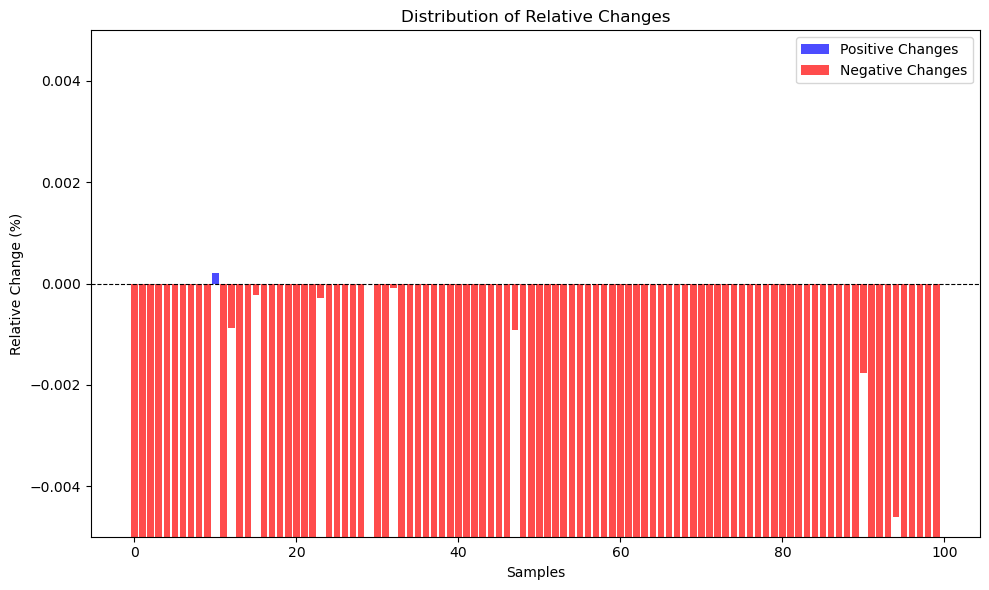


Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.186
Overall Relative Change (ORC) positive changes      :  0.022 %
Overall Relative Change (ORC) negative changes      : -78.595 %


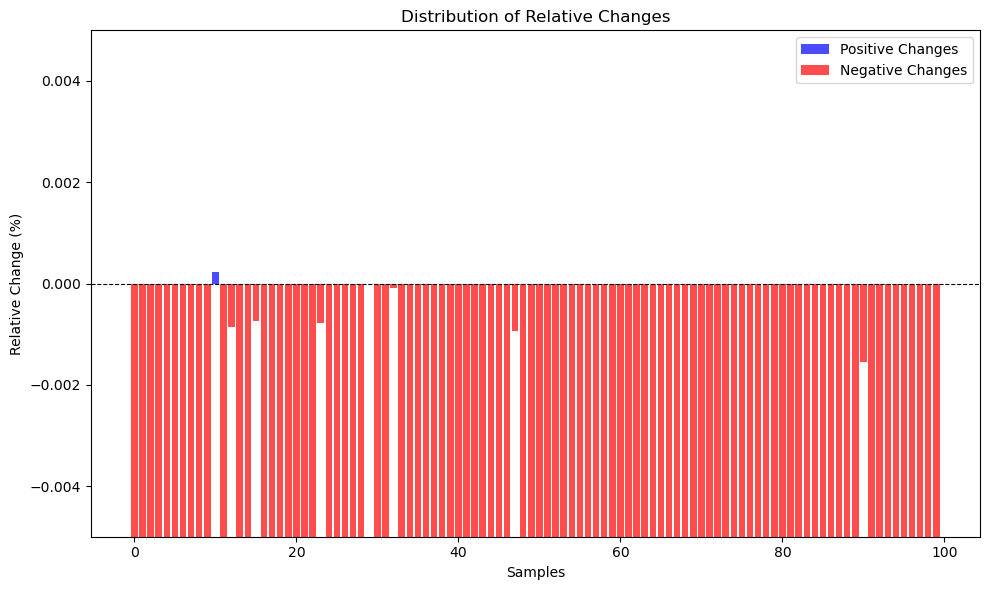


Classification accuracy                             :  0.89
Explanations Contribution Score (ECS) of Full Text  :  0.964
Explanations Contribution Score (ECS) of Top Tokens :  0.189
Overall Relative Change (ORC) positive changes      :  0.032 %
Overall Relative Change (ORC) negative changes      : -79.117 %


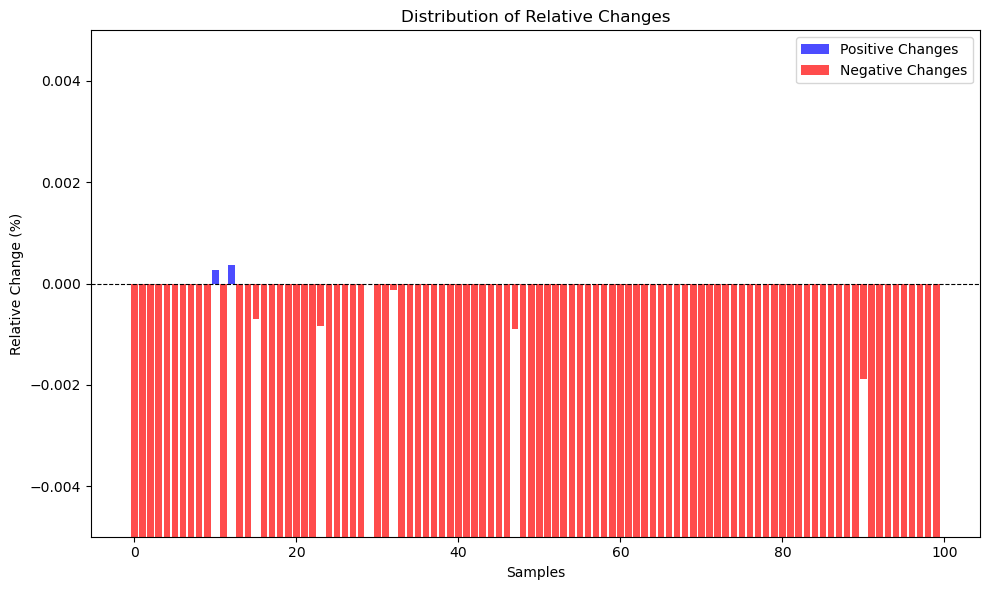

In [53]:
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.5][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.6][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)
all_exp_results = pd.concat([all_exp_results, pd.DataFrame([evaluate_explanations(tc32_tbt_results[0.7][1])], 
                                                           columns=all_exp_results.columns)], ignore_index=True)

## Final Results

In [54]:
all_exp_results

,Cl Acc,ECS FT,ECS TT,ORC (+),ORC (-)
0,0.88,0.972,0.906,8.504,-9.251
1,0.88,0.972,0.909,7.011,-9.055
2,0.88,0.972,0.915,6.581,-8.413
3,0.75,0.839,0.556,6.708,-32.169
4,0.75,0.839,0.562,6.142,-33.242
5,0.75,0.839,0.540,7.347,-34.972
6,0.84,0.934,0.712,9.009,-30.453
7,0.84,0.934,0.698,8.254,-32.560
8,0.84,0.934,0.716,8.231,-29.770
9,0.95,0.993,0.489,10.597,-51.560


In [56]:
excel_file = path_reports + 'all_exp_results.xlsx'

with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    all_exp_results.to_excel(writer, sheet_name='SHAP', index=False)